In [1]:
import gzip
import os
import numpy as np
import datetime
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, r2_score
import pandas as pd
from ctgan.synthesizers import CTGAN, TVAE
from sdv.evaluation import evaluate

In [2]:
class BenchmarkMLP(nn.Module):
    def __init__(self, input_dim=784, output_dim=10, hidden_dim=100) -> None:
        super(BenchmarkMLP, self).__init__()
        num_layers = 1
        layer_dim = (hidden_dim,)
        self.layers = []
        dim = input_dim
        for i in range(num_layers):
            self.layers.append(
                nn.Linear(dim, layer_dim[i])
            )
            self.layers.append(nn.ReLU())
            dim = layer_dim[i]
        self.layers.append(
            nn.Linear(dim, output_dim)
        )
        self.layers = nn.ModuleList(self.layers)
        self.layers.apply(self.init_weights)

    def init_weights(self, layer):
        if isinstance(layer, nn.Linear):
            torch.nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [43]:
def scorer(output, target, scorer_type, model_type, f1_class):
    if scorer_type == "f1_macro" and model_type == "classification":
        return f1_score(target.argmax(-1), output.argmax(-1), average="macro")
    elif scorer_type == "f1_micro" and model_type == "classification":
        return f1_score(target.argmax(-1), output.argmax(-1), average="micro")
    elif scorer_type == "accuracy" and model_type == "classification":
        correct = (target.argmax(-1) == output.argmax(-1)).sum()
        total = target.shape[0]
        return correct/total
    elif scorer_type in ("f1_minority", "f1_majority") and model_type == "classification" and f1_class is not None:
        return f1_score(target.argmax(-1), output.argmax(-1), average="binary", pos_label=f1_class)
    elif scorer_type == "r2" and model_type == "regression":
        return r2_score(target, output)
    else:
        raise Exception(f"Invalid scorer type: {scorer_type} and model type: {model_type} combination")

def train_model(
    train_X,
    train_y,
    valid_X,
    valid_y,
    test_X,
    test_y,
    input_dim=784,
    output_dim=10,
    num_epochs=10,
    batch_size=64,
    device="cuda",
    model_type="classification",
    verbose=True,
    use_best_validation=True,
    hidden_dim=100,
    show_print_training_score=False,
    scorer_type="f1_macro"
):
    # scorer_type supported: f1_macro, f1_micro, f1_minority, f1_majority, r2, accuracy
    # model_type supported: regression, classification
    train_len = train_X.shape[0]
    num_batches_per_epoch = train_len // batch_size
    if train_len % batch_size != 0:
        num_batches_per_epoch += 1
    if model_type == "classification":
        critetion = nn.CrossEntropyLoss()
        unique_elements, counts = np.unique(train_y.argmax(-1), return_counts=True)
        if scorer_type == "f1_minority":
            f1_class = unique_elements[np.argmin(counts)]
        elif scorer_type == "f1_majority":
            f1_class = unique_elements[np.argmax(counts)]
        else:
            f1_class = None
    elif model_type == "regression":
        critetion = nn.MSELoss()
        f1_class = None
    else:
        raise Exception("Invalid model_type argument")

    model = BenchmarkMLP(input_dim=input_dim, output_dim=output_dim, hidden_dim=hidden_dim).to(device)
    optimizer = optim.Adam(model.parameters())

    train_X = torch.Tensor(train_X).to(device)
    train_y = torch.Tensor(train_y).to(device)
    valid_X = torch.Tensor(valid_X).to(device)
    valid_y = torch.Tensor(valid_y).to(device)
    test_X = torch.Tensor(test_X).to(device)
    test_y = torch.Tensor(test_y).to(device)

    best_valid_score = -float("inf")
    best_model_weights = model.state_dict()
    for epoch in tqdm(range(num_epochs)):
        model.train()
        idx = 0
        epoch_loss = 0
        train_score = 0
        # Shuffle train_X and train_y before every epoch
        random_ids = np.random.permutation(train_len)
        train_X = train_X[random_ids]
        train_y = train_y[random_ids]
        for _ in range(num_batches_per_epoch):
            input = train_X[idx : idx + batch_size]
            targets = train_y[idx : idx + batch_size]
            idx += batch_size
            output = model(input)
            loss = critetion(output, targets)
            if show_print_training_score:
                train_score += scorer(output.cpu().detach(), targets.cpu().detach(), scorer_type, model_type, f1_class)
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if model_type == "classification":
            epoch_loss = epoch_loss / train_len
        elif model_type == "regression":
            epoch_loss = epoch_loss / num_batches_per_epoch
        else:
            raise Exception("Invalid model_type argument")
        train_score = train_score / num_batches_per_epoch

        model.eval()
        with torch.no_grad():
            output = model(valid_X)
            if model_type == "classification":
                valid_loss = critetion(output, valid_y) / valid_y.shape[0]
            elif model_type == "regression":
                valid_loss = critetion(output, valid_y)
            else:
                raise Exception("Invalid model_type argument")
            valid_score = scorer(output.cpu().detach(), valid_y.cpu().detach(), scorer_type, model_type, f1_class)
            if valid_score > best_valid_score:
                best_valid_score = valid_score
                best_model_weights = model.state_dict()

        if verbose or epoch % 25 == 0:
            if show_print_training_score:
                print(f"Epoch: {epoch + 1}, Training Loss: {epoch_loss:.4f}, Training Score: {train_score:.4f}, Valid Loss: {valid_loss:.4f}, Valid score: {valid_score:.4f}")
            else:
                print(f"Epoch: {epoch + 1}, Training Loss: {epoch_loss:.4f}, Valid Loss: {valid_loss:.4f}, Valid score: {valid_score:.4f}")

    print(f"Best validation score: {best_valid_score}")
    if use_best_validation:
        model.load_state_dict(best_model_weights)
    model.eval()
    with torch.no_grad():
        output = model(test_X)
        test_score = scorer(output.cpu().detach(), test_y.cpu().detach(), scorer_type, model_type, f1_class)
    
    return test_score

In [164]:
def load_mnist(path="dataset/mnist/"):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST. Default is
            /home/USER/data/mnist or C:\Users\USER\data\mnist.
            Create if nonexistant. Download any missing files.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.

    https://mattpetersen.github.io/load-mnist-with-numpy
    Load from /home/USER/data/mnist or elsewhere; download if missing.
    """

    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        # return pixels.reshape(-1, 784).astype('float32') / 255
        return (pixels.reshape(-1, 784) != 0).astype(np.int8)

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    mnist_test_X = _images(os.path.join(path, files[2]))
    mnist_test_y = _labels(os.path.join(path, files[3]))

    mnist_train_X, mnist_valid_X, mnist_train_y, mnist_valid_y = train_test_split(train_images, train_labels, test_size=0.1, random_state=1, shuffle=True, stratify=train_labels.argmax(-1))

    return mnist_train_X, mnist_train_y, mnist_valid_X, mnist_valid_y, mnist_test_X, mnist_test_y

In [163]:
def load_fake_mnist(path="dataset/mnist/", synthesizer="ctgan", num_epochs=30, pretrained=""):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST. Default is
            /home/USER/data/mnist or C:\Users\USER\data\mnist.
            Create if nonexistant. Download any missing files.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.

    https://mattpetersen.github.io/load-mnist-with-numpy
    Load from /home/USER/data/mnist or elsewhere; download if missing.
    """

    files = [
        'train-images-idx3-ubyte.gz',
        'train-labels-idx1-ubyte.gz',
    ]

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        # return pixels.reshape(-1, 784).astype('float32') / 255
        return (pixels.reshape(-1, 784) != 0).astype(np.int8)

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    train_data = np.concatenate((train_images, train_labels.argmax(-1)[:,None]), axis=1)
    if synthesizer == "ctgan":
        if pretrained:
            model = CTGAN.load(pretrained)
        else:
            model = CTGAN(batch_size=10**3, epochs=num_epochs)
    elif synthesizer == "tvae":
        if pretrained:
            model = TVAE.load(pretrained)
        else:
            model = TVAE(batch_size=10**3, epochs=num_epochs)
    else:
        print(f"Synthesizer {synthesizer} not defined!")
        return
    if not pretrained:
        model.fit(train_data, discrete_columns=list(range(train_data.shape[1])))
        # Training fake data synthesizer for MNIST takes a lot of time, save the model to reuse it
        now = datetime.datetime.now()
        current_time = now.strftime("%d-%m-%Y-%H-%M-%S")
        model.save(f"../models/mnist_{synthesizer}_{num_epochs}_epochs_{current_time}.pkl")
    fake_data = model.sample(train_data.shape[0])

    mnist_fake_train_X, mnist_fake_valid_X, mnist_fake_train_y, mnist_fake_valid_y = train_test_split(fake_data[:,:-1], np.eye(10)[fake_data[:,-1]], test_size=0.1, random_state=1, shuffle=True, stratify=fake_data[:,-1])

    return mnist_fake_train_X, mnist_fake_train_y, mnist_fake_valid_X, mnist_fake_valid_y

In [15]:
def load_credit(path="dataset/credit/"):
    credit_df = pd.read_csv(f"{path}creditcard.csv")
    credit_train_y = credit_df.pop("Class").to_numpy()
    credit_train_y = np.eye(2)[credit_train_y]
    credit_train_X = credit_df.to_numpy()
    credit_train_X, credit_test_X, credit_train_y, credit_test_y = train_test_split(credit_train_X, credit_train_y, test_size=20000, random_state=1, shuffle=True, stratify=credit_train_y)
    credit_train_X, credit_valid_X, credit_train_y, credit_valid_y = train_test_split(credit_train_X, credit_train_y, test_size=10000, random_state=1, shuffle=True, stratify=credit_train_y)

    return credit_train_X, credit_train_y, credit_valid_X, credit_valid_y, credit_test_X, credit_test_y

In [161]:
def load_fake_credit(path="../dataset/credit/", synthesizer="ctgan", num_epochs=50, pretrained="", data_fraction=0.25):
    credit_df = pd.read_csv(f"{path}creditcard.csv")
    # Only use a fraction of dataset using stratified sampling to maintain class samples ratio
    # This is especially useful for hyperparameter tuning of epochs
    credit_df = credit_df.groupby("Class").apply(lambda x: x.sample(frac=data_fraction))
    if synthesizer == "ctgan":
        if pretrained:
            model = CTGAN.load(pretrained)
        else:
            model = CTGAN(epochs=num_epochs)
    elif synthesizer == "tvae":
        if pretrained:
            model = TVAE.load(pretrained)
        else:
            model = TVAE(epochs=num_epochs)
    else:
        print(f"Synthesizer {synthesizer} not defined!")
        return
    if not pretrained:
        model.fit(credit_df, discrete_columns=["Class"])
        # Training fake data synthesizer for credit takes a lot of time, save the model to reuse it
        now = datetime.datetime.now()
        current_time = now.strftime("%d-%m-%Y-%H-%M-%S")
        model.save(f"../models/credit_{synthesizer}_{num_epochs}_epochs_{current_time}.pkl")
    fake_df = model.sample(credit_df.shape[0])
    credit_fake_train_y = fake_df.pop("Class").to_numpy()
    credit_fake_train_y = np.eye(2)[credit_fake_train_y]
    credit_fake_train_X = fake_df.to_numpy()
    credit_fake_train_X, credit_fake_valid_X, credit_fake_train_y, credit_fake_valid_y = train_test_split(
        credit_fake_train_X,
        credit_fake_train_y,
        test_size=0.1,
        random_state=1,
        shuffle=True,
        stratify=credit_fake_train_y.argmax(-1)
    )
    return credit_fake_train_X, credit_fake_train_y, credit_fake_valid_X, credit_fake_valid_y


In [46]:
def load_adult(path="dataset/adult/"):
    adult_train_df = pd.read_csv(f"{path}adult.data", header=None)
    adult_test_df = pd.read_csv(f"{path}adult.test", header=None)
    columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income_50k"]
    cat_columns = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country", "income_50k"]
    adult_train_df.columns = columns
    adult_test_df.columns = columns
    adult_train_df = pd.get_dummies(adult_train_df, cat_columns)
    adult_test_df = pd.get_dummies(adult_test_df, cat_columns)
    # Remove extra . at the end in the test set
    adult_test_df["income_50k_ >50K"] = adult_test_df.pop("income_50k_ >50K.")
    adult_test_df["income_50k_ <=50K"] = adult_test_df.pop("income_50k_ <=50K.")
    # Add missing columns in test
    missing_columns = list(set(adult_train_df.columns) - set(adult_test_df.columns))
    for col_name in missing_columns:
        adult_test_df[col_name] = 0
    # Sort columns to ensure same ordering in train and test data frames
    adult_train_df = adult_train_df.reindex(sorted(adult_train_df.columns), axis=1)
    adult_test_df = adult_test_df.reindex(sorted(adult_train_df.columns), axis=1)
    adult_train_y = adult_train_df[["income_50k_ >50K", "income_50k_ <=50K"]].to_numpy()
    adult_train_X = adult_train_df.drop(["income_50k_ >50K", "income_50k_ <=50K"], axis=1).to_numpy()
    adult_test_y = adult_test_df[["income_50k_ >50K", "income_50k_ <=50K"]].to_numpy()
    adult_test_X = adult_test_df.drop(["income_50k_ >50K", "income_50k_ <=50K"], axis=1).to_numpy()
    adult_train_X, adult_valid_X, adult_train_y, adult_valid_y = train_test_split(adult_train_X, adult_train_y, test_size=0.1, random_state=1, shuffle=True, stratify=adult_train_y.argmax(-1))

    return adult_train_X, adult_train_y, adult_valid_X, adult_valid_y, adult_test_X, adult_test_y 

In [7]:
def load_fake_adult(path="dataset/adult/", synthesizer="ctgan", num_epochs=50):
    adult_train_df = pd.read_csv(f"{path}adult.data", header=None)
    columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income_50k"]
    cat_columns = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country", "income_50k"]
    adult_train_df.columns = columns

    if synthesizer == "ctgan":
        model = CTGAN(epochs=num_epochs)
    elif synthesizer == "tvae":
        model = TVAE(epochs=num_epochs)
    else:
        print(f"Synthesizer {synthesizer} not defined!")
        return
    model.fit(adult_train_df, discrete_columns=cat_columns)
    fake_df = model.sample(adult_train_df.shape[0])
    fake_df = pd.get_dummies(fake_df, cat_columns)
    adult_train_df = pd.get_dummies(adult_train_df, cat_columns)
    # Add missing columns in test
    missing_columns = list(set(adult_train_df.columns) - set(fake_df.columns))
    for col_name in missing_columns:
        fake_df[col_name] = 0
    # Sort columns to ensure same ordering in train and test data frames
    fake_df = fake_df.reindex(sorted(adult_train_df.columns), axis=1)
    adult_fake_train_X = fake_df.drop(["income_50k_ >50K", "income_50k_ <=50K"], axis=1).to_numpy()
    adult_fake_train_y = fake_df[["income_50k_ >50K", "income_50k_ <=50K"]].to_numpy()
    adult_fake_train_X, adult_fake_valid_X, adult_fake_train_y, adult_fake_valid_y = train_test_split(
        adult_fake_train_X, adult_fake_train_y, test_size=0.1, random_state=1, shuffle=True, stratify=adult_fake_train_y.argmax(-1)
    )

    return adult_fake_train_X, adult_fake_train_y, adult_fake_valid_X, adult_fake_valid_y

In [59]:
def load_news(path="../dataset/news/"):
    news_df = pd.read_csv(f"{path}/OnlineNewsPopularity.csv")
    # Remove leading whitespace from column names
    news_df.columns = [col_name.lstrip() for col_name in news_df.columns.to_list()]
    # Set categorical columns
    cat_columns = [
        "data_channel_is_lifestyle",
        "data_channel_is_entertainment",
        "data_channel_is_bus",
        "data_channel_is_socmed",
        "data_channel_is_tech",
        "data_channel_is_world",
        "weekday_is_monday",
        "weekday_is_tuesday",
        "weekday_is_wednesday",
        "weekday_is_thursday",
        "weekday_is_friday",
        "weekday_is_saturday",
        "weekday_is_sunday",
        "is_weekend",
    ]
    for col_name in cat_columns:
        news_df[col_name] = news_df[col_name].astype("category")
    # Remove url column
    news_df = news_df.drop(columns=["url"])
    # Do not perform one hot encoding since the categorical columns are already binary valued
    news_train_y = news_df.pop("shares").to_numpy()[..., None]
    news_train_X = news_df.to_numpy()
    news_train_X, news_test_X, news_train_y, news_test_y = train_test_split(news_train_X, news_train_y, test_size=8000, random_state=1, shuffle=True)
    news_train_X, news_valid_X, news_train_y, news_valid_y = train_test_split(news_train_X, news_train_y, test_size=0.1, random_state=1, shuffle=True)
    return news_train_X, news_train_y, news_valid_X, news_valid_y, news_test_X, news_test_y

In [70]:
def load_intrusion(path="../dataset/intrusion/"):
    columns = [
        "duration",
        "protocol_type",
        "service",
        "flag",
        "src_bytes",
        "dst_bytes",
        "land",
        "wrong_fragment",
        "urgent",
        "hot",
        "num_failed_logins",
        "logged_in",
        "num_compromised",
        "root_shell",
        "su_attempted",
        "num_root",
        "num_file_creations",
        "num_shells",
        "num_access_files",
        "num_outbound_cmds",
        "is_host_login",
        "is_guest_login",
        "count",
        "srv_count",
        "serror_rate",
        "srv_serror_rate",
        "rerror_rate",
        "srv_rerror_rate",
        "same_srv_rate",
        "diff_srv_rate",
        "srv_diff_host_rate",
        "dst_host_count",
        "dst_host_srv_count",
        "dst_host_same_srv_rate",
        "dst_host_diff_srv_rate",
        "dst_host_same_src_port_rate",
        "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate",
        "dst_host_srv_serror_rate",
        "dst_host_rerror_rate",
        "dst_host_srv_rerror_rate",
        "class"
    ]
    multi_class_columns = [
        "wrong_fragment",
        "urgent",
        "hot",
        "num_failed_logins",
        "num_compromised",
        "su_attempted",
        "num_root",
        "num_file_creations",
        "num_shells",
        "num_access_files",
        "protocol_type",
        "service",
        "flag",
    ]
    binary_columns = ["land", "logged_in", "root_shell", "is_guest_login"]

    intrusion_df = pd.read_csv(f"{path}kddcup.data_10_percent", header=None)
    intrusion_df.columns = columns
    # remove columns: num_outbound_cmds, is_host_login since they contain the same value and provide no extra information
    intrusion_df = intrusion_df.drop(columns=["num_outbound_cmds", "is_host_login"])
    for col in binary_columns:
        intrusion_df[col] = intrusion_df[col].astype(np.int8)
    for col in multi_class_columns:
        intrusion_df[col] = intrusion_df[col].astype("category")
    intrusion_df = pd.get_dummies(intrusion_df, columns=multi_class_columns)

    intrusion_y = pd.get_dummies(intrusion_df["class"]).to_numpy()
    intrusion_X = intrusion_df.drop(columns=["class"]).to_numpy()

    intrusion_train_X, intrusion_test_X, intrusion_train_y, intrusion_test_y = train_test_split(
        intrusion_X, intrusion_y, test_size=int(1e5), random_state=1, shuffle=True, stratify=intrusion_y.argmax(-1)
    )
    intrusion_train_X, intrusion_valid_X, intrusion_train_y, intrusion_valid_y = train_test_split(
        intrusion_train_X, intrusion_train_y, test_size=0.1, random_state=1, shuffle=True, stratify=intrusion_train_y.argmax(-1)
    )
    return intrusion_train_X, intrusion_train_y, intrusion_valid_X, intrusion_valid_y, intrusion_test_X, intrusion_test_y

In [78]:
def load_covtype(path="../dataset/covtype/"):
    covtype_arr = pd.read_csv(f"{path}covtype.data", header=None).to_numpy()
    num_classes = np.unique(covtype_arr[:,-1]).shape[0]
    # classes are from 1 to 7 so subtract by one
    covtype_y = np.eye(num_classes)[covtype_arr[:,-1] - 1]
    covtype_X = covtype_arr[:,:-1]
    covtype_train_X, covtype_test_X, covtype_train_y, covtype_test_y = train_test_split(
        covtype_X, covtype_y, test_size=int(1e5), random_state=1, shuffle=True, stratify=covtype_y.argmax(-1)
    )
    covtype_train_X, covtype_valid_X, covtype_train_y, covtype_valid_y = train_test_split(
        covtype_train_X, covtype_train_y, test_size=0.1, random_state=1, shuffle=True, stratify=covtype_train_y.argmax(-1)
    )
    return covtype_train_X, covtype_train_y, covtype_valid_X, covtype_valid_y, covtype_test_X, covtype_test_y

In [24]:
def load_census(path="../dataset/census/"):
    columns = [
        "age",
        "class of worker",
        "detailed industry recode",
        "detailed occupation recode",
        "education",
        "wage per hour",
        "enroll in edu inst last wk",
        "marital stat",
        "major industry code",
        "major occupation code",
        "race",
        "hispanic origin",
        "sex",
        "member of a labor union",
        "reason for unemployment",
        "full or part time employment stat",
        "capital gains",
        "capital losses",
        "dividends from stocks",
        "tax filer stat",
        "region of previous residence",
        "state of previous residence",
        "detailed household and family stat",
        "detailed household summary in household",
        "instance weight",
        "migration code-change in msa",
        "migration code-change in reg",
        "migration code-move within reg",
        "live in this house 1 year ago",
        "migration prev res in sunbelt",
        "num persons worked for employer",
        "family members under 18",
        "country of birth father",
        "country of birth mother",
        "country of birth self",
        "citizenship",
        "own business or self employed",
        "fill inc questionnaire for veteran's admin",
        "veterans benefits",
        "weeks worked in year",
        "year",
        "income"
    ]
    binary_columns = [
        "sex",
        "year",
        "income",
    ]
    cont_columns = [
        "age",
        "wage per hour",
        "capital gains",
        "capital losses",
        "dividends from stocks",
        "num persons worked for employer",
        "weeks worked in year",
        "instance weight",
    ]
    multi_class_columns = list(set(columns) - set(binary_columns) - set(cont_columns))

    census_df_train = pd.read_csv(f"{path}/census-income.data", header=None)
    census_df_test = pd.read_csv(f"{path}/census-income.test", header=None)
    census_df_train.columns = columns
    census_df_test.columns = columns
    # Set correct datatype
    for col in binary_columns:
        # Perform binary encoding
        val_dict = dict((val, pos) for pos, val in enumerate(census_df_train[col].unique()))
        census_df_train[col] = census_df_train[col].replace(val_dict)
        census_df_test[col] = census_df_test[col].replace(val_dict)
        census_df_train[col] = census_df_train[col].astype(np.uint8)
        census_df_test[col] = census_df_train[col].astype(np.uint8)
    for col in cont_columns:
        census_df_train[col] = census_df_train[col].astype(np.float32)
        census_df_test[col] = census_df_train[col].astype(np.float32)
    for col in multi_class_columns:
        census_df_train[col] = census_df_train[col].astype("category")
        census_df_test[col] = census_df_train[col].astype("category")
    # Perform one hot encoding of multi class columns
    census_df_train = pd.get_dummies(census_df_train, columns=multi_class_columns)
    census_df_test = pd.get_dummies(census_df_test, columns=multi_class_columns)
    # Split into X and y
    census_train_y = census_df_train.pop("income").to_numpy()
    census_train_y = np.eye(2)[census_train_y]
    census_train_X = census_df_train.to_numpy()
    census_test_y = census_df_test.pop("income").to_numpy()[..., None]
    census_test_y = np.eye(2)[census_test_y]
    census_test_X = census_df_test.to_numpy()
    # Create validation data
    census_train_X, census_valid_X, census_train_y, census_valid_y = train_test_split(
        census_train_X, census_train_y, test_size=0.1, random_state=1, shuffle=True, stratify=census_train_y
    )
    return census_train_X, census_train_y, census_valid_X, census_valid_y, census_test_X, census_test_y

In [168]:
mnist_train_X, mnist_train_y, mnist_valid_X, mnist_valid_y, mnist_test_X, mnist_test_y = load_mnist("../dataset/mnist/")

test_score = train_model(
    mnist_train_X,
    mnist_train_y,
    mnist_valid_X,
    mnist_valid_y,
    mnist_test_X,
    mnist_test_y,
    input_dim=784,
    output_dim=10,
    batch_size=64,
    num_epochs=10,
    model_type="classification"
)
print(f"Test score: {test_score}")

#### Best test F1 macro score for real mnist train data is: 0.96

In [16]:
credit_train_X, credit_train_y, credit_valid_X, credit_valid_y, credit_test_X, credit_test_y = load_credit("../dataset/credit/")

test_score = train_model(
    credit_train_X,
    credit_train_y,
    credit_valid_X,
    credit_valid_y,
    credit_test_X,
    credit_test_y,
    input_dim=30,
    output_dim=2,
    batch_size=2**12,
    num_epochs=200,
    model_type="classification",
    scorer_type="f1_minority",
    verbose=False,
)
print(f"Test score: {test_score}")

#### Best test minority class F1 score for real credit train data is: 0.63

In [47]:
adult_train_X, adult_train_y, adult_valid_X, adult_valid_y, adult_test_X, adult_test_y = load_adult("../dataset/adult/")

test_score = train_model(
    adult_train_X,
    adult_train_y,
    adult_valid_X,
    adult_valid_y,
    adult_test_X,
    adult_test_y,
    input_dim=108,
    output_dim=2,
    batch_size=256,
    num_epochs=100,
    model_type="classification",
    verbose=False,
    scorer_type="f1_minority",
)
print(f"Test score: {test_score}")

#### Best test minority class F1 macro score for real adult train data is: 0.60

In [60]:
news_train_X, news_train_y, news_valid_X, news_valid_y, news_test_X, news_test_y = load_news("../dataset/news/")

test_score = train_model(
    news_train_X,
    news_train_y,
    news_valid_X,
    news_valid_y,
    news_test_X,
    news_test_y,
    input_dim=59,
    output_dim=1,
    batch_size=256,
    num_epochs=100,
    model_type="regression",
    show_print_training_score=False,
    scorer_type="r2",
    verbose=False
)
print(f"Test score: {test_score}")

#### Best test R2 score for real news train data is: 0.027

In [71]:
intrusion_train_X, intrusion_train_y, intrusion_valid_X, intrusion_valid_y, intrusion_test_X, intrusion_test_y = load_intrusion("../dataset/intrusion/")

test_score = train_model(
    intrusion_train_X,
    intrusion_train_y,
    intrusion_valid_X,
    intrusion_valid_y,
    intrusion_test_X,
    intrusion_test_y,
    input_dim=215,
    output_dim=23,
    batch_size=2**12,
    num_epochs=300,
    model_type="classification",
    show_print_training_score=False,
    verbose=False,
    scorer_type="f1_macro",
)
print(f"Test score: {test_score}")

#### Best test F1 macro score for real intrusion train data is: 0.70

In [79]:
covtype_train_X, covtype_train_y, covtype_valid_X, covtype_valid_y, covtype_test_X, covtype_test_y = load_covtype("../dataset/covtype/")

test_score = train_model(
    covtype_train_X,
    covtype_train_y,
    covtype_valid_X,
    covtype_valid_y,
    covtype_test_X,
    covtype_test_y,
    input_dim=54,
    output_dim=7,
    batch_size=2**12,
    num_epochs=300,
    model_type="classification",
    show_print_training_score=False,
    verbose=False,
    scorer_type="f1_macro"
)
print(f"Test score: {test_score}")

#### Best test F1 macro score for real covtype train data is: 0.63

In [82]:
census_train_X, census_train_y, census_valid_X, census_valid_y, census_test_X, census_test_y = load_census("../dataset/census/")

test_score = train_model(
    census_train_X,
    census_train_y,
    census_valid_X,
    census_valid_y,
    census_test_X,
    census_test_y,
    input_dim=509,
    output_dim=2,
    batch_size=2**12,
    num_epochs=200,
    model_type="classification",
    show_print_training_score=False,
    verbose=False,
    scorer_type="f1_minority"
)
print(f"Test score: {test_score}")

#### Best test minority class F1 score for real census train data is: 0.59

## MNIST dataset

### CTGAN

In [21]:
mnist_fake_train_X, mnist_fake_train_y, mnist_fake_valid_X, mnist_fake_valid_y = load_fake_mnist(
    "../dataset/mnist/",
    synthesizer="ctgan",
    num_epochs=30,
    pretrained="../models/mnist_ctgan_200_epochs_02-04-2023-01-10-12.pkl"
)

8


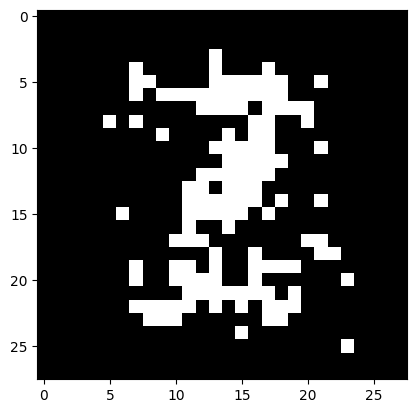

In [37]:
idx = np.random.randint(1, mnist_fake_train_X.shape[0])
plt.imshow(mnist_fake_train_X[idx,:].reshape(28, 28), cmap="gray")
print(mnist_fake_train_y[idx].argmax(-1))

test_score = train_model(
    mnist_fake_train_X,
    mnist_fake_train_y,
    mnist_fake_valid_X,
    mnist_fake_valid_y,
    mnist_test_X,
    mnist_test_y,
    input_dim=784,
    output_dim=10,
    batch_size=64,
    num_epochs=10,
    model_type="classification"
)
print(f"Test score: {test_score}")

#### Best test (real data) F1 macro score for fake mnist CTGAN (200 epochs) train data is: 0.39

#### I did not perform number of epochs tuning for MNIST CTGAN, however, 200 epochs produces the same result as mentioned in CTGAN paper

### TVAE

### TVAE mode collapses for more than 100 epochs

In [18]:
result_dict = dict()
files_dict = {
    130: "../models/mnist_tvae_130_epochs_03-04-2023-07-10-43.pkl",
    100: "../models/mnist_tvae_100_epochs_03-04-2023-03-44-27.pkl",
    90: "../models/mnist_tvae_90_epochs_03-04-2023-06-45-09.pkl",
    70: "../models/mnist_tvae_70_epochs_03-04-2023-06-26-29.pkl",
    50: "../models/mnist_tvae_50_epochs_03-04-2023-06-11-41.pkl",
    30: "../models/mnist_tvae_30_epochs_03-04-2023-02-37-09.pkl"
}
train_data = np.concatenate((mnist_train_X, mnist_train_y.argmax(-1)[:,None]), axis=1)
for num_epoch in files_dict:
    print(f"Num epoch: {num_epoch}")
    model = TVAE.load(files_dict[num_epoch])
    fake_data = model.sample(train_data.shape[0])
    score = evaluate(pd.DataFrame(fake_data), pd.DataFrame(train_data))
    result_dict[num_epoch] = score

Num epoch: 130
Num epoch: 100
Num epoch: 90
Num epoch: 70
Num epoch: 50
Num epoch: 30


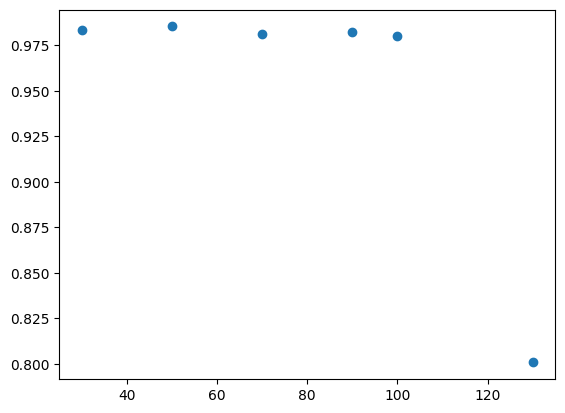

In [20]:
epochs_list = list(result_dict.keys())
plt.scatter(x=epochs_list, y=[result_dict[num_epoch] for num_epoch in epochs_list])

### 100 epochs seems to produce the best result

2


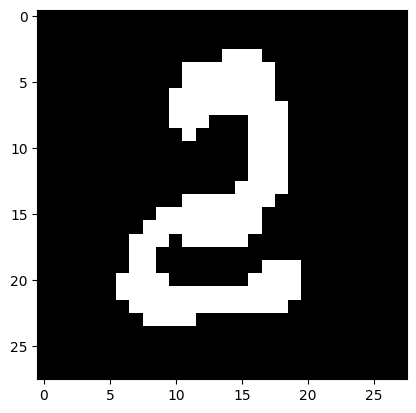

In [22]:
tvae = TVAE.load("../models/mnist_tvae_100_epochs_03-04-2023-03-44-27.pkl")
fake = tvae.sample(1)
plt.imshow(fake[0][:-1].reshape(28, 28), cmap="gray")
print(fake[0][-1])

In [31]:
mnist_fake_train_X, mnist_fake_train_y, mnist_fake_valid_X, mnist_fake_valid_y = load_fake_mnist(
    "../dataset/mnist/",
    synthesizer="tvae",
    num_epochs=100,
    pretrained="../models/mnist_tvae_30_epochs_03-04-2023-02-37-09.pkl",
)

test_score = train_model(
    mnist_fake_train_X,
    mnist_fake_train_y,
    mnist_fake_valid_X,
    mnist_fake_valid_y,
    mnist_test_X,
    mnist_test_y,
    input_dim=784,
    output_dim=10,
    batch_size=64,
    num_epochs=10,
    model_type="classification"
)
print(f"Test score: {test_score}")

#### Best test (real data) F1 macro score for fake mnist VAE (100 epochs) train data is: 0.91

## Adult dataset

#### CTGAN

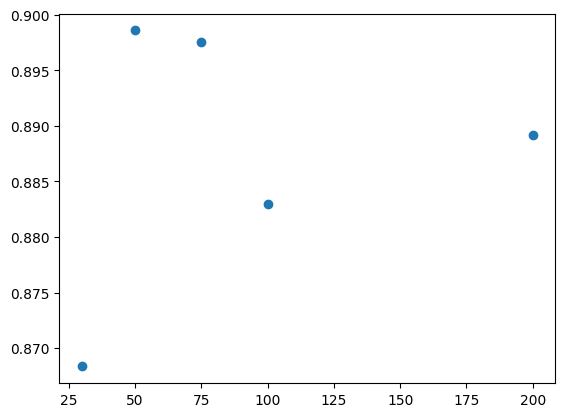

In [12]:
plt.scatter(x=results.keys(), y=results.values())

##### 50 epochs produced the best SDV fake data evaluation score for CTGAN, we will use 50 epochs for VAE as well

### TVAE

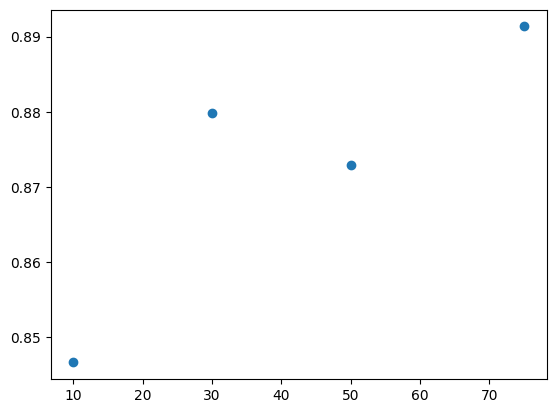

In [27]:
# VAE is unable to train for >= 100 epochs
vae_results
plt.scatter(x=vae_results.keys(), y=vae_results.values())

### TVAE decoder sigmas gets nan if we train for more than 100 epochs

### ML efficacy of CTGAN on Adult dataset

In [30]:
adult_fake_train_X, adult_fake_train_y, adult_fake_valid_X, adult_fake_valid_y = load_fake_adult(path="../dataset/adult/", synthesizer="ctgan")

100%|██████████| 50/50 [01:32<00:00,  1.84s/it]


SDV fake data evaluation score: 0.8906754803308501


test_score = train_model(
    adult_fake_train_X,
    adult_fake_train_y,
    adult_fake_valid_X,
    adult_fake_valid_y,
    adult_test_X,
    adult_test_y,
    input_dim=108,
    output_dim=2,
    batch_size=128,
    num_epochs=50,
    model_type="classification",
    verbose=False,
)
print(f"Test score: {test_score}")

#### Best test (real data) F1 macro score for fake adult CTGAN (50 epochs) train data is: 0.70

### ML efficacy of TVAE on Adult dataset

In [32]:
adult_fake_train_X, adult_fake_train_y, adult_fake_valid_X, adult_fake_valid_y = load_fake_adult(path="../dataset/adult/", synthesizer="tvae")

100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


SDV fake data evaluation score: 0.8878818538755011


test_score = train_model(
    adult_fake_train_X,
    adult_fake_train_y,
    adult_fake_valid_X,
    adult_fake_valid_y,
    adult_test_X,
    adult_test_y,
    input_dim=108,
    output_dim=2,
    batch_size=128,
    num_epochs=50,
    model_type="classification",
    verbose=False,
)
print(f"Test score: {test_score}")

#### Best test (real data) F1 macro score for fake adult TVAE (50 epochs) train data is: 0.70

## Credit dataset

### For epoch tuning use only 25% of stratified data

### CTGAN

In [ ]:
result_dict = dict()
files_dict = {
    30: "../models/credit_ctgan_30_epochs_03-04-2023-00-28-44.pkl",
    50: "../models/credit_ctgan_50_epochs_03-04-2023-00-35-27.pkl",
    75: "../models/credit_ctgan_75_epochs_03-04-2023-00-44-07.pkl",
    100: "../models/credit_ctgan_100_epochs_03-04-2023-00-54-47.pkl",
    200: "../models/credit_ctgan_200_epochs_03-04-2023-01-13-22.pkl",
}
for num_epoch in files_dict:
    print(f"Num epoch: {num_epoch}")
    credit_fake_train_X, credit_fake_train_y, credit_fake_valid_X, credit_fake_valid_y = load_fake_credit(
        path="../dataset/credit/", synthesizer="ctgan", pretrained=files_dict[num_epoch]
    )
    score = evaluate(pd.DataFrame(credit_fake_train_X), pd.DataFrame(credit_train_X))
    result_dict[num_epoch] = score

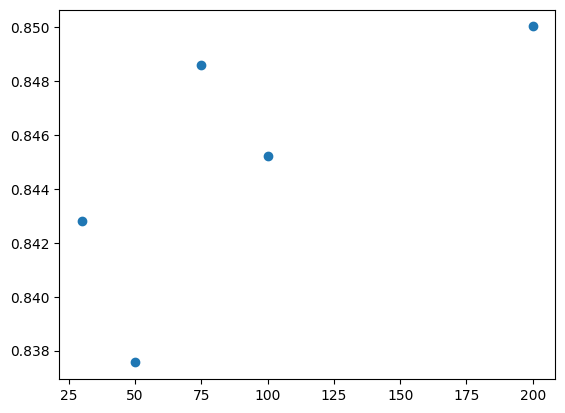

In [14]:
epochs_list = list(result_dict.keys())
plt.scatter(x=epochs_list, y=[result_dict[num_epoch] for num_epoch in epochs_list])

#### 200 epochs seems to give the best result

### TVAE

In [ ]:
result_dict = dict()
files_dict = {
    30: "../models/credit_tvae_30_epochs_03-04-2023-01-17-32.pkl",
    50: "../models/credit_tvae_50_epochs_03-04-2023-01-22-37.pkl",
    75: "../models/credit_tvae_75_epochs_03-04-2023-01-28-54.pkl",
    100: "../models/credit_tvae_100_epochs_03-04-2023-01-36-23.pkl",
    200: "../models/credit_tvae_200_epochs_03-04-2023-01-48-38.pkl",
}
for num_epoch in files_dict:
    print(f"Num epoch: {num_epoch}")
    credit_fake_train_X, credit_fake_train_y, credit_fake_valid_X, credit_fake_valid_y = load_fake_credit(
        path="../dataset/credit/", synthesizer="tvae", pretrained=files_dict[num_epoch]
    )
    score = evaluate(pd.DataFrame(credit_fake_train_X), pd.DataFrame(credit_train_X))
    result_dict[num_epoch] = score

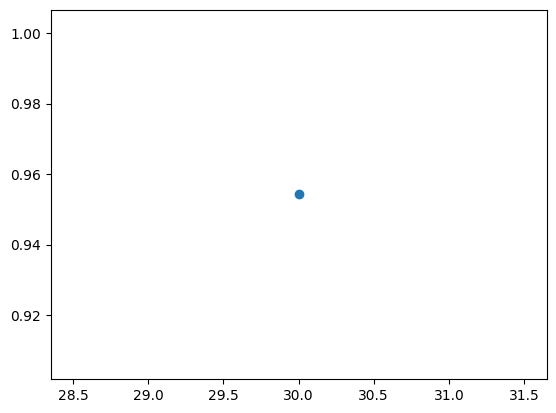

In [22]:
epochs_list = list(result_dict.keys())
plt.scatter(x=epochs_list, y=[result_dict[num_epoch] for num_epoch in epochs_list])

### TVAE decoder sigmas gets nan if we train for more than 30 epochs

### Train models (CTGAN for 200 epochs and TVAE for 30 epochs) on whole dataset

### ML efficacy of CTGAN on Credit dataset

In [270]:
credit_fake_train_X, credit_fake_train_y, credit_fake_valid_X, credit_fake_valid_y = load_fake_credit(
    path="../dataset/credit/", synthesizer="ctgan", pretrained="../models/credit_ctgan_200_epochs_03-04-2023-12-59-48.pkl", data_fraction=1.0
)
score = evaluate(pd.DataFrame(credit_fake_train_X), pd.DataFrame(credit_train_X))
print(score)

/home/vigu/pyenvs/vanilla/lib/python3.8/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator BayesianGaussianMixture from version 1.2.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


0.8453021381237456


test_score = train_model(
    credit_fake_train_X,
    credit_fake_train_y,
    credit_fake_valid_X,
    credit_fake_valid_y,
    credit_test_X,
    credit_test_y,
    input_dim=30,
    output_dim=2,
    batch_size=256,
    num_epochs=20,
    model_type="classification",
)
print(f"Test score: {test_score}")

#### Best test (real data) F1 macro score for fake credit CTGAN (200 epochs) train data is: 0.56

### CTGAN model trained on 25% data performs comparable to that trained on 100% data!

### ML efficacy of TVAE on Credit dataset

In [281]:
credit_fake_train_X, credit_fake_train_y, credit_fake_valid_X, credit_fake_valid_y = load_fake_credit(
    path="../dataset/credit/", synthesizer="tvae", pretrained="../models/credit_tvae_30_epochs_03-04-2023-01-17-32.pkl", data_fraction=1.0
)
score = evaluate(pd.DataFrame(credit_fake_train_X), pd.DataFrame(credit_train_X))
print(score)

/home/vigu/pyenvs/vanilla/lib/python3.8/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator BayesianGaussianMixture from version 1.2.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


0.9544779128701518


test_score = train_model(
    credit_fake_train_X,
    credit_fake_train_y,
    credit_fake_valid_X,
    credit_fake_valid_y,
    credit_test_X,
    credit_test_y,
    input_dim=30,
    output_dim=2,
    batch_size=256,
    num_epochs=20,
    model_type="classification",
    verbose=False,
)
print(f"Test score: {test_score}")

### TVAE decoder sigmas gets nan if we train on whole dataset for 30 epochs

#### Best test (real data) F1 macro score for fake credit TVAE (30 epochs) train data is: 0.60